In [16]:
#OLAP DEMO
#This script demonstrates basic OLAP operations using the pandas library in Python.
#ROLAP, MOLAP and HOLAP

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:

#database connection
def create_connection(db_file="olab_demo.db"):
    conn = sqlite3.connect(db_file)
    return conn

In [18]:
#create a sample database

employees =pd.DataFrame({
    'emp_id':[1,2,3,4,5],
    'name':['Alice','Bob','Charlie','David','Eva'],
    'dept_id':[1, 2, 1, 3, 2],
    'age':[30,35,40,28,32],
    'salary':[7000, 50000, 6000, 10000, 8000]
})

departments = pd.DataFrame({
    'dept_id':[1,2,3],
    'dept_name':['HR','Engineering','Sales']
})


In [19]:
#load data into SQl database
conn = create_connection()
employees.to_sql('employees', conn, if_exists='replace', index=False)
departments.to_sql('departments', conn, if_exists='replace', index=False)

print("Tables created: departments, employees")

Tables created: departments, employees


In [20]:
#perform OLAP operations

#ROLAP Operations
query = """
SELECT d.dept_id, AVG(e.Salary) as avg_salary
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
GROUP BY d.dept_id
"""

rolap_result = pd.read_sql_query(query, conn)
print("\nROLAP Result (SQL Aggregation):")
print(rolap_result)


ROLAP Result (SQL Aggregation):
   dept_id  avg_salary
0        1      6500.0
1        2     29000.0
2        3     10000.0


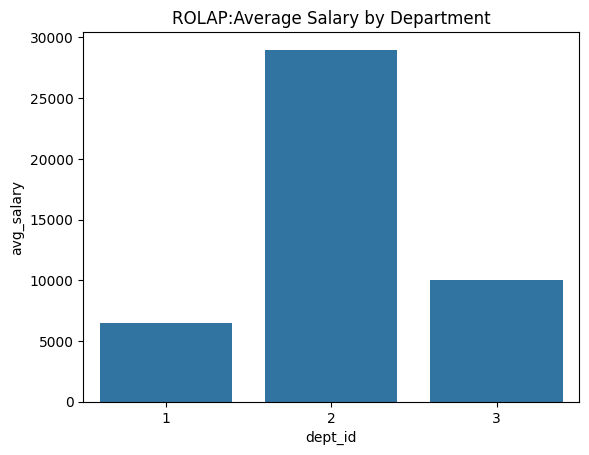

In [23]:
#VISUALIZATION: Roll-up by department
sns.barplot(x='dept_id', y='avg_salary', data=rolap_result)
plt.title('ROLAP:Average Salary by Department')
plt.show()

In [24]:
#MOLAP Operations
#Using pandas for in-memory aggregation

molap_cube = pd.pivot_table(
    employees.merge(departments, on='dept_id'),
    values='salary',
    index=['dept_name'],
    columns='age',
    aggfunc=np.mean,
    fill_value=0
)


C:\Users\cselue\AppData\Local\Temp\ipykernel_15948\499680306.py:4: FutureWarning: The provided callable <function mean at 0x000001FC7F7B5580> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  molap_cube = pd.pivot_table(


In [25]:

print("\nMOLAP Cube (Department vs Age):")
print(molap_cube)


MOLAP Cube (Department vs Age):
age               28      30      32       35      40
dept_name                                            
Engineering      0.0     0.0  8000.0  50000.0     0.0
HR               0.0  7000.0     0.0      0.0  6000.0
Sales        10000.0     0.0     0.0      0.0     0.0


<module 'matplotlib.pyplot' from 'C:\\Users\\cselue\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

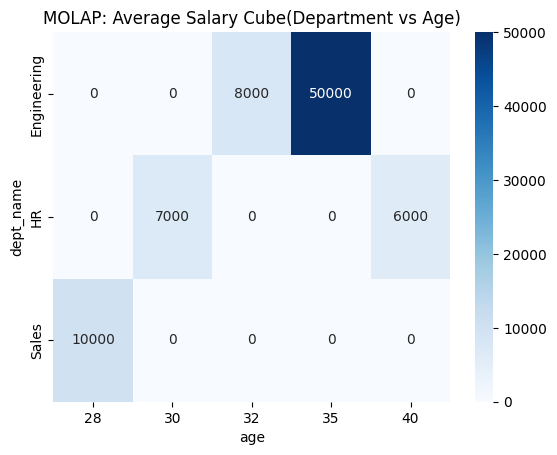

In [26]:
#VISUALIZATION: MOALP cube heatmap
sns.heatmap(molap_cube, annot=True, fmt=".0f", cmap="Blues")
plt.title('MOLAP: Average Salary Cube(Department vs Age)')
plt

In [27]:
#HOLAP Operations
#Combining ROLAP and MOLAP approaches

detail_sql = """
SELECT e.name, e.salary, d.dept_name
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
"""

In [28]:
detail_sql=pd.read_sql_query(detail_sql, conn)

In [ ]:
#pandas MOLAP aggregation
holap_summary = detail_sql.groupby('dept_name')['salary'].mean().reset_index()

In [32]:
print("\nHOLAP Summary (Average Salary by Department):")
print(holap_summary)


HOLAP Summary (Average Salary by Department):
     dept_name   salary
0  Engineering  29000.0
1           HR   6500.0
2        Sales  10000.0


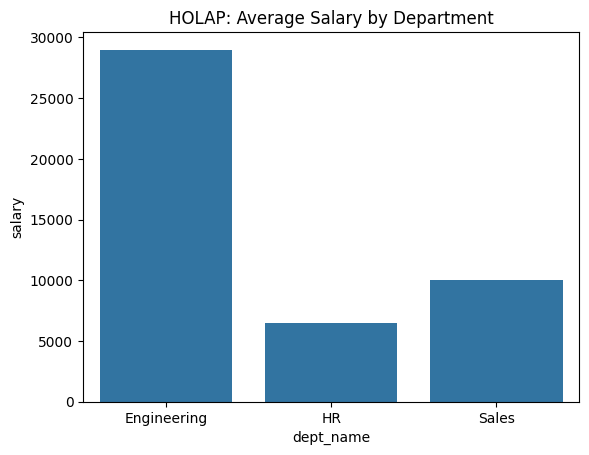

In [33]:
#VISUALIZATION: HOLAP summary
sns.barplot(x='dept_name', y='salary', data=holap_summary)
plt.title('HOLAP: Average Salary by Department')
plt.show()

In [37]:
#OLAP Operations demonstrated using ROLAP, MOLAP, and HOLAP approaches.

#slice
slice_df=detail_sql[detail_sql['dept_name']=='Sales']
print("\nSlice (Sales Department):")
print(slice_df)


Slice (Sales Department):
    name  salary dept_name
3  David   10000     Sales


In [47]:
#dice
dice_df = detail_sql[(detail_sql['dept_name']=='HR')& (detail_sql['salary']>6000)]
print("\nDice (HR Department with Salry > 6000):")
print(dice_df)


Dice (HR Department with Salry > 6000):
    name  salary dept_name
0  Alice    7000        HR


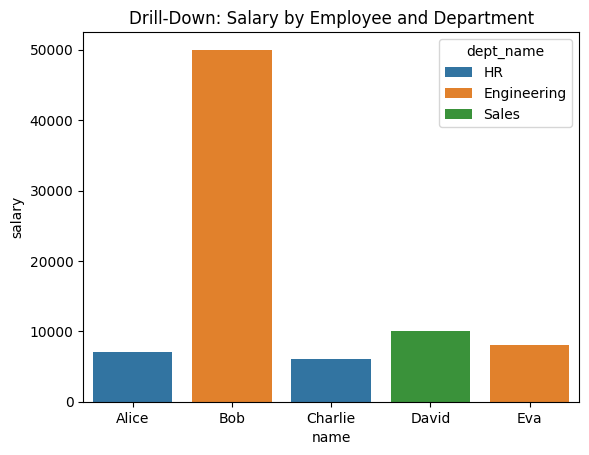

In [48]:
#drill-down

sns.barplot(data=detail_sql, x='name', y='salary', hue='dept_name')
plt.title('Drill-Down: Salary by Employee and Department')
plt.show()

In [49]:
#rollup
rollup_df = detail_sql.groupby('dept_name')['salary'].sum().reset_index()
print("\nRoll-Up (Total Salary by Department):")
print(rollup_df)


Roll-Up (Total Salary by Department):
     dept_name  salary
0  Engineering   58000
1           HR   13000
2        Sales   10000


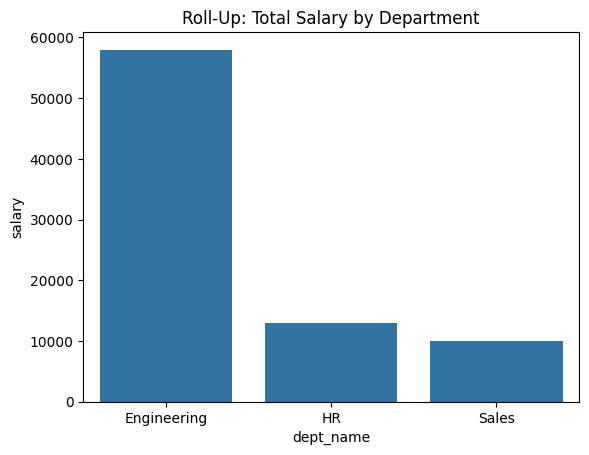

In [50]:
#visualization: rollup
sns.barplot(x='dept_name', y='salary', data=rollup_df)
plt.title('Roll-Up: Total Salary by Department')
plt.show()

In [51]:
#close the database connection
conn.close()